<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/19_genetic_light_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи о поездах с помощью генетического алгоритма


Есть `T` поездов заданной вместимости (`capacity`) и `С` грузов заданного веса (`cargo`). Требуется распределить груз по поездам наиболее оптимальным способом.

Со значениями, которые были в исходном ноутбуке, невозможно полностью распределить грузы по поездам, так что данные были подобраны так, чтобы решение сходилось.

## Настройка окружения

In [0]:
import numpy as np
import pandas as pd
from numpy.random import randint
from random import sample

import matplotlib.pyplot as plt
%matplotlib inline 

## Решение

Задаём входные данные – вместимость поездов и вес грузов

In [0]:
capacity = np.array([10, 18, 6, 15, 9, 3, 2, 22])
cargo = np.array([5, 10, 2, 2, 8, 16, 4, 11, 1, 3, 1, 1, 7, 4, 3, 2, 1, 2, 2])

trains_count = len(capacity)
cargo_count = len(cargo)


Бот – массив из `C` целых чисел от `0` до `T-1`. Число на позиции `i` – это номер поезда, на который распределяется `i`-й груз

In [0]:
class Bot:
    def __init__(self, parents=[], mutation_rate=0):
        if len(parents) == 0:
            # Создание случайного бота
            self.cells = randint(trains_count, size=cargo_count)
        else:
            # Создание бота-потомка
            produce_cells = np.vectorize(lambda i: self.inherit_cell(parents, mutation_rate, i))

            self.cells = produce_cells(np.arange(cargo_count))

        self.score = self.calculate_score()

    def __str__(self):
        return f"{self.score} | {self.cells}"

    # наследование одной ячейки
    def inherit_cell(self, parents, mutation_rate, cell_index):
        mutate = np.random.rand()

        if mutate > mutation_rate:
            rnd = randint(len(parents))
            return parents[rnd].cells[cell_index]
        else:
            return randint(trains_count)

    # функция оценки бота
    load_quality = np.vectorize(lambda item: 1000 if item < 0 else item)

    def calculate_score(self):
        load = np.zeros(trains_count, dtype=int)
        for i in range(cargo_count):
            load[self.cells[i]] += cargo[i]

        return sum(abs(capacity - load))


Evolution – моделирование эволюции ботов

In [0]:
class Evolution:
    get_scores = np.vectorize(lambda bot: bot.score)

    def __init__(self, size=100, survivors=50, mutation=0.5, parents_count=2):
        # размер популяции
        self.size = size

        # сколько выживает на каждом шаге
        self.survivors = survivors

        # сколько создаётся на каждом шаге
        self.new = self.size - self.survivors

        # доля мутации
        self.mutation = mutation

        # от скольки родителей будут наследоваться новые боты
        self.parents_count = parents_count

        # популяция ботов: случайное распределение
        self.generation = np.vectorize(lambda i: Bot())(np.arange(0, self.size))

    def stat(self):
        total_score = np.vectorize(lambda bot: bot.score)(self.generation)
        mean_val = sum(total_score) / self.size
        min_val = np.min(total_score)

        return mean_val, min_val

    def sorted_scores(self):
        scores = Evolution.get_scores(self.generation)
        return sorted(scores)

    def next_generation(self):
        sorted_bots = sorted(self.generation, key=lambda b: b.score)
        new_gen = np.array(sorted_bots[:self.survivors])
        np.random.shuffle(new_gen)
        for i in range(self.new):
            # родителями могут быть только выжившие на текущей итерации
            parent_ids = sample(range(self.survivors), self.parents_count)
            parents = new_gen[parent_ids]
            bot = Bot(parents, self.mutation)
            new_gen = np.append(new_gen, bot)

        self.generation = new_gen

    def best_bot(self):
        return sorted(self.generation, key=lambda b: b.score)[0]


Запуск генетического алгоритма. При достижении функцией наилучшего бота нулевого значения процесс останавливается.

In [295]:
evo = Evolution(size=200, survivors=50, mutation=0.1, parents_count=4)

means = []
mins = []

for epoch in range(250):
    mean_val, min_val = evo.stat()
    
    means.append(mean_val)
    mins.append(min_val)
    
    print(f"{epoch}\t Mean {mean_val}, min {min_val}\t{evo.sorted_scores()[:20]}")
    if min_val == 0:
        print(f"Found a solution on epoch {epoch}")
        break
    evo.next_generation()


0	 Mean 70.67, min 22	[22, 30, 34, 36, 38, 40, 40, 42, 42, 44, 44, 44, 44, 46, 46, 46, 48, 48, 48, 48]
1	 Mean 53.86, min 14	[14, 20, 22, 24, 28, 28, 30, 30, 30, 30, 32, 32, 32, 32, 34, 34, 34, 36, 36, 38]
2	 Mean 46.83, min 10	[10, 14, 18, 20, 20, 22, 24, 24, 24, 26, 26, 28, 28, 28, 28, 30, 30, 30, 30, 30]
3	 Mean 44.37, min 10	[10, 14, 18, 18, 20, 20, 20, 22, 22, 24, 24, 24, 26, 26, 26, 26, 26, 28, 28, 28]
4	 Mean 40.68, min 10	[10, 14, 16, 16, 18, 18, 20, 20, 20, 20, 22, 22, 22, 22, 22, 24, 24, 24, 24, 24]
5	 Mean 40.87, min 10	[10, 14, 16, 16, 18, 18, 18, 20, 20, 20, 20, 20, 20, 22, 22, 22, 22, 22, 24, 24]
6	 Mean 36.86, min 10	[10, 14, 16, 16, 16, 18, 18, 18, 18, 20, 20, 20, 20, 20, 20, 22, 22, 22, 22, 22]
7	 Mean 37.46, min 10	[10, 12, 14, 14, 16, 16, 16, 16, 18, 18, 18, 18, 18, 20, 20, 20, 20, 20, 20, 20]
8	 Mean 36.73, min 10	[10, 12, 14, 14, 16, 16, 16, 16, 18, 18, 18, 18, 18, 18, 18, 18, 20, 20, 20, 20]
9	 Mean 35.45, min 10	[10, 12, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 16

Вывод наилучшего найденного решения:

In [282]:
best_bot = evo.best_bot()
print("The Best solution", best_bot.cells)
print()

dist = {i: [] for i in range(trains_count)}
for i in range(cargo_count):
    dist[best_bot.cells[i]].append(cargo[i])

for i in range(trains_count):
    print(f"train {i}, capacity {capacity[i]}, cargo: {dist[i]}")

The Best solution [1 0 1 7 3 7 7 1 6 2 3 2 4 3 5 3 6 4 2]

train 0, capacity 10, cargo: [10]
train 1, capacity 18, cargo: [5, 2, 11]
train 2, capacity 6, cargo: [3, 1, 2]
train 3, capacity 15, cargo: [8, 1, 4, 2]
train 4, capacity 9, cargo: [7, 2]
train 5, capacity 3, cargo: [3]
train 6, capacity 2, cargo: [1, 1]
train 7, capacity 22, cargo: [2, 16, 4]


График подбора

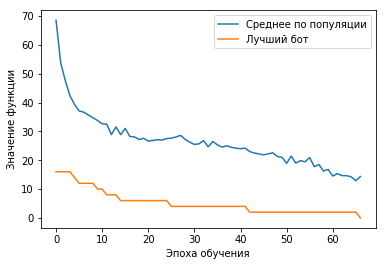

In [283]:
plt.plot(means, label='Среднее по популяции')
plt.plot(mins, label='Лучший бот')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции')
plt.legend()
plt.show()

# Наблюдения

* Чем больше размер популяции, тем быстрее находится решение
* Увеличение mutation_rate обычно замедляет нахождение решения
* Получение решения нестабильно и не гарантировано: оно может быть найдено за 25 эпох, за 100 или не найдено вообще.